In [23]:
import warnings
warnings.filterwarnings("ignore")

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import matplotlib.patches as mpatches
from _utils import *

In [25]:
# Set default setting for the figures.
plt.style.use("default") # style matplotlib
plt.rc("axes", labelsize = 12) # fontsize of the x and y labels
plt.rc("axes", titlesize = 15) # fontsize of the axes title
plt.rc("xtick", labelsize = 12) # fontsize of the tick labels
plt.rc("ytick", labelsize = 12) # fontsize of the tick labels
plt.rc("legend", fontsize = 12) # legend fontsize

# Load data

In [26]:
# Load data satellite.
xls = pd.ExcelFile("./Data/RadiationCloudsBiomass.xlsx")

Radiation_data = pd.read_excel(xls, "All Area", index_col = 0)
Radiation_data_wet = pd.read_excel(xls, "Wet Region", index_col = 0)
Radiation_data_season = pd.read_excel(xls, "Seasonal Rn", header = [1], index_col = 0)
Radiation_data_season_SW = pd.read_excel(xls,"Seasonal SW", header = [1], index_col = 0)

In [27]:
# Preprocessing.
Radiation_data.dropna(axis = 1, how = "all", inplace = True)
Radiation_data.dropna(inplace = True)

Radiation_data_wet.dropna(axis = 1, how = "all", inplace = True)
Radiation_data_wet.dropna(inplace = True)

Radiation_data_season.dropna(inplace = True)

Radiation_data_season_SW.dropna(inplace = True)

In [28]:
RF = pd.read_csv("./Data/forcing_output.csv", index_col = [0, 1])
RF.head()

DELTA_crossing  area_albedo_cloud  area_albedo_cloud_check  \
Season Latitude                                                               
1      0               0.927070       4.902642e+05            -2.914014e+05   
       1               0.862255       5.429565e+05            -3.718562e+05   
       2               1.137331      -7.939047e+05            -8.014589e+05   
       3               1.786072      -1.732916e+06            -1.737830e+06   
       4               2.709593      -3.024175e+06            -3.027040e+06   

                   area_albedo  Carbon_eq  Carbon_eq_cloud  
Season Latitude                                             
1      0         938155.393598   0.001697         0.001697  
       1         947402.035973   0.001886         0.001886  
       2         956978.747465  -0.002828        -0.002828  
       3         966884.287649  -0.006222        -0.006222  
       4         977117.162052  -0.010842        -0.010842

In [29]:
# Map dictionary for seasons.
dict_seasons = {1: "DJF", 2: "MAM", 3: "JJA", 4: "SON"}

# Analysis

In [30]:
# Define latitudes.
latitudes = RF.index.get_level_values("Latitude").unique()
latitudes

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65],
           dtype='int64', name='Latitude')

In [31]:
# Carbon equivalent forcing data.
forest_cf = Radiation_data_wet["forest cloud fraction percentage"]
grass_cf = Radiation_data_wet["grass cloud fraction percentage"]
forest_rf = Radiation_data_wet["forest net radiation W/m2"]
grass_rf = Radiation_data_wet["grass net radiation w/m2"]
forest_biomass = Radiation_data_wet["forest (Mg C/ha)"]
grass_biomass = Radiation_data_wet["grass (Mg C /ha)"]

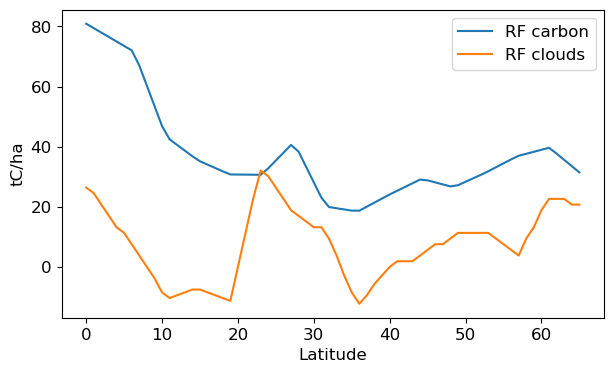

In [11]:
Delta_cf = (forest_cf - grass_cf).dropna()
Delta_rf = (forest_rf - grass_rf).dropna()

D_Cf = interp1d(Delta_cf.index.values, Delta_cf.values, fill_value = "extrapolate")(latitudes)
D_RF = interp1d(Delta_rf.index.values, Delta_rf.values, fill_value = "extrapolate")(latitudes)
Delta_biomass = forest_biomass - grass_biomass
# Carbon equivalent of RF from data.
DeltaRF_C = 10000*RF_to_Ceq(D_RF)  
DeltaC = interp1d(forest_cf.index.values, Delta_biomass.values, fill_value = "extrapolate")(latitudes)

# Plot.
fig, ax = plt.subplots(figsize = (7, 4))

ax.plot(DeltaC, label = "RF carbon")
ax.plot(DeltaRF_C, label = "RF clouds")
# Set attributes of the plot.
ax.set_ylabel("tC/ha")
ax.set_xlabel("Latitude")
ax.legend();

In [12]:
# Seasonal case.
Rn = dict()
for season_id, season in dict_seasons.items():
    Rn[season_id] = pd.Series(interp1d(Radiation_data_season.index.values, Radiation_data_season[season].values, fill_value = "extrapolate")(latitudes))
    Rn[season_id].index = latitudes
# Shortwave data.
SW = dict()
for season_id, season in dict_seasons.items():
    SW[season_id] = pd.Series(interp1d(Radiation_data_season_SW.index.values, Radiation_data_season_SW[season].values, fill_value = "extrapolate")(latitudes))
    SW[season_id].index = latitudes

In [13]:
# Concatenate satellite data.
Radiation_data_satellite = pd.concat({"Rn": pd.concat(Rn).unstack(0), "SW": pd.concat(SW).unstack(0)}, axis = 1)
Radiation_data_satellite.columns.names = ["Radiation", "Season"]
Radiation_data_satellite = Radiation_data_satellite.stack("Season")
Radiation_data_satellite = Radiation_data_satellite.reorder_levels([1, 0], axis = 0).sort_index(axis = 0, level = [0, 1])
Radiation_data_satellite.head()

Radiation               Rn        SW
Season Latitude                     
1      0         17.009389  8.601069
       1         13.460678  4.210334
       2          9.911966 -0.180401
       3          6.363254 -4.571136
       4          2.814543 -8.961871

In [14]:
#XXX change from area_albedo_cloud to 
Radiation_data = pd.concat([Radiation_data_satellite, RF[["area_albedo_cloud"]]/86400], axis = 1)
Radiation_data.rename({"area_albedo_cloud": "Model"}, axis = 1, inplace = True)
Radiation_data.head()

Rn        SW      Model
Season Latitude                                
1      0         17.009389  8.601069   5.674355
       1         13.460678  4.210334   6.284219
       2          9.911966 -0.180401  -9.188712
       3          6.363254 -4.571136 -20.056900
       4          2.814543 -8.961871 -35.002029

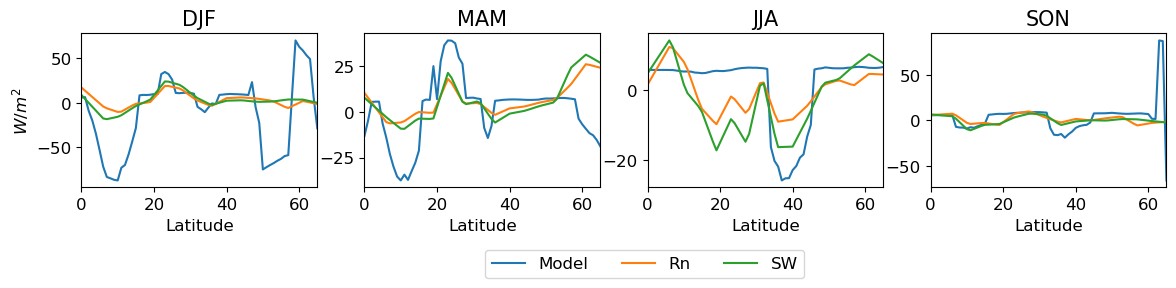

In [15]:
# Create figure object.
fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize = (14, 2), sharex = True)
fig.subplots_adjust(wspace = .2, hspace = .7)

seasons = [1, 2, 3, 4]

ax1 = axs.flatten()[:4]
for i, (season, ax) in enumerate(zip(seasons, ax1)):
    Radiation_data[["Model"]].loc[season].plot(ax = ax, legend = False)
    Radiation_data[["Rn"]].loc[season].plot(ax = ax, legend = False)
    Radiation_data[["SW"]].loc[season].plot(ax = ax, legend = False)  
    # Set attributes of the plot.
    ax.set_title(f"{dict_seasons[season]}")
    if i == 0:
        ax.set_ylabel("$W/m^2$")
# Add unique legend.
ax1[-1].legend(bbox_to_anchor = (-0.5, -0.35), ncol = 3);

In [16]:
annual_radiation_data = Radiation_data.groupby(axis = 0, level = "Latitude").mean()
annual_radiation_data.head()

,Rn,SW,Model
Latitude,,,
0,8.688971,6.935591,0.997730
1,7.653084,5.704533,3.282258
2,6.617197,4.473475,1.979850
3,5.581309,3.242417,-0.694693
4,4.545422,2.011359,-4.426698


In [17]:
#annual_radiation_data.plot()

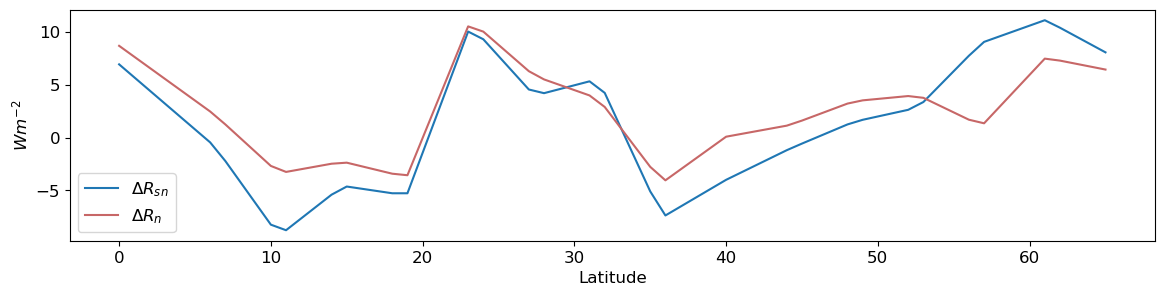

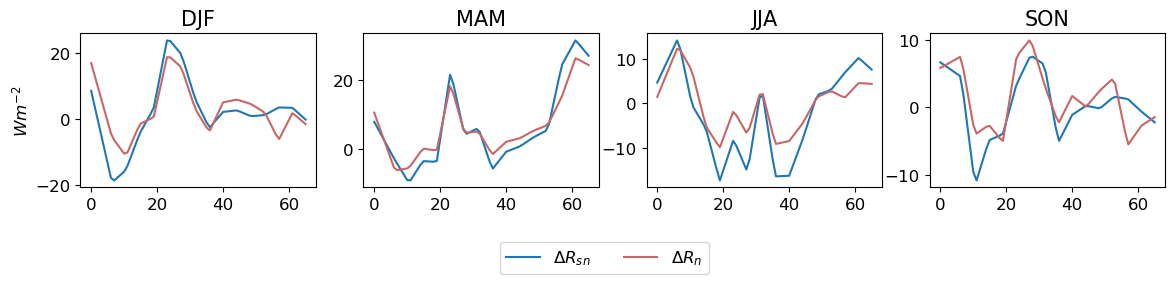

In [18]:
#plot for comparison total vs shortwave radiation
fig, ax = plt.subplots(figsize = (14, 3))
ax.plot(annual_radiation_data["SW"], label = "$\\Delta R_{sn}$")
ax.plot(annual_radiation_data["Rn"], label = "$\\Delta R_{n}$",  color = "#c76767")
ax.set_xlabel("Latitude")
ax.set_ylabel("$W m^{-2}$")
ax.legend()

# Create figure object.
fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize = (14, 2), sharex = True)
fig.subplots_adjust(wspace = .2, hspace = .7)

seasons = [1, 2, 3, 4]

ax1 = axs.flatten()[:4]
for i, (season, ax) in enumerate(zip(seasons, ax1)):
    ax.plot(Radiation_data[["SW"]].loc[season], label = "$\\Delta R_{sn}$")
    ax.plot(Radiation_data[["Rn"]].loc[season], label = "$\\Delta R_{n}$", color = "#c76767")
    # Set attributes of the plot.
    ax.set_title(f"{dict_seasons[season]}")
    if i == 0:
        ax.set_ylabel("$W m^{-2}$")
# Add unique legend.
ax1[-1].legend(bbox_to_anchor = (-0.9, -0.3), ncol = 2);

In [19]:
# Average without winter.
Radiation_data_no_winter = Radiation_data.loc[Radiation_data.index.get_level_values("Season").isin([2, 3, 4]), :]
annual_radiation_data_no_winter = Radiation_data_no_winter.groupby(axis = 0, level = "Latitude").mean()
annual_radiation_data_no_winter.head()

,Rn,SW,Model
Latitude,,,
0,5.915499,6.380432,-0.561145
1,5.717220,6.202599,2.281605
2,5.518940,6.024767,5.702704
3,5.320661,5.846935,5.759375
4,5.122382,5.669103,5.765079


In [20]:
#annual_radiation_data_no_winter.plot()

In [44]:
Delta_cf.index.values[0]

array([ 2.10526316,  6.31578947, 10.52631579, 14.73684211, 18.94736842,
       23.15789474, 27.36842105, 31.57894737, 35.78947368, 40.        ,
       44.21052632, 48.42105263, 52.63157895, 56.84210526, 61.05263158,
       65.26315789])

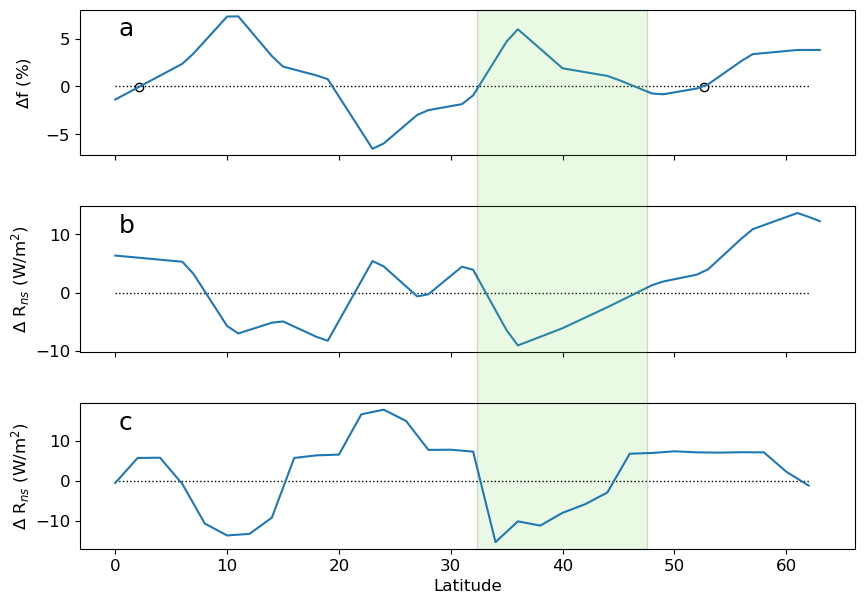

In [57]:
fig, axs = plt.subplots(3, sharex = True, figsize = (10, 7))
fig.subplots_adjust(wspace = 0.1, hspace = 0.35)

# Figure 1.

axs[0].plot(latitudes[:64],D_Cf[:64])
#axs[0].scatter(Delta_cf.index.values[:-1],interp1d(Delta_cf.index.values, Delta_cf.values)(Delta_cf.index.values[:-1]), c='black')
axs[0].scatter(Delta_cf.index.values[0], interp1d(Delta_cf.index.values, Delta_cf.values)(Delta_cf.index.values[0]) , facecolors='white', edgecolors='black')
axs[0].scatter(Delta_cf.index.values[12], interp1d(Delta_cf.index.values, Delta_cf.values)(Delta_cf.index.values[12]) ,facecolors='white', edgecolors='black')
axs[0].set_ylabel(ylabel = "$\Delta$f (%)", labelpad = 9)
axs[0].hlines(0.0, 0, latitudes[-4], linestyle = ":", linewidth = 1, label = '')
# Figure 2.
#axs[1].scatter(Delta_rf.index.values[:-1],interp1d(latitudes[:64],annual_radiation_data_no_winter["SW"][:64])(Delta_rf.index.values[:-1]), c='black')
axs[1].plot(annual_radiation_data_no_winter["SW"][:64])
axs[1].set_ylabel(ylabel = "$\Delta$ R$_{ns}$ (W/m$^2$)", labelpad = 2)
axs[1].get_shared_y_axes()
axs[1].hlines(0.0, 0, latitudes[-4], linestyle = ":", linewidth = 1, label = '')
# Figure 3.
axs[2].plot(annual_radiation_data_no_winter["Model"][:64:2])
axs[2].set_xlabel("Latitude")
axs[2].set_ylabel(ylabel = "$\Delta$ R$_{ns}$ (W/m$^2$)", labelpad = 2)
axs[2].get_shared_y_axes()
axs[2].hlines(0.0, 0, latitudes[-4], linestyle = ":", linewidth = 1, label = '')
axs[0].text(0.05, 0.95, 'a', transform = axs[0].transAxes, fontsize = 18, va = 'top')
axs[1].text(0.05, 0.95, 'b', transform = axs[1].transAxes, fontsize = 18, va = 'top')
axs[2].text(0.05, 0.95, 'c', transform = axs[2].transAxes, fontsize = 18, va = 'top')

rect = mpatches.Rectangle([0.522, 0.110], 0.17, 0.770, ec = 'k', fc = '#6ddb4b', alpha = 0.15, 
                          clip_on = False, transform = fig.transFigure)
axs[2].add_patch(rect)
# Save figure.
fig.savefig("./Figures/4. Plot/panel.png", dpi = 1200)

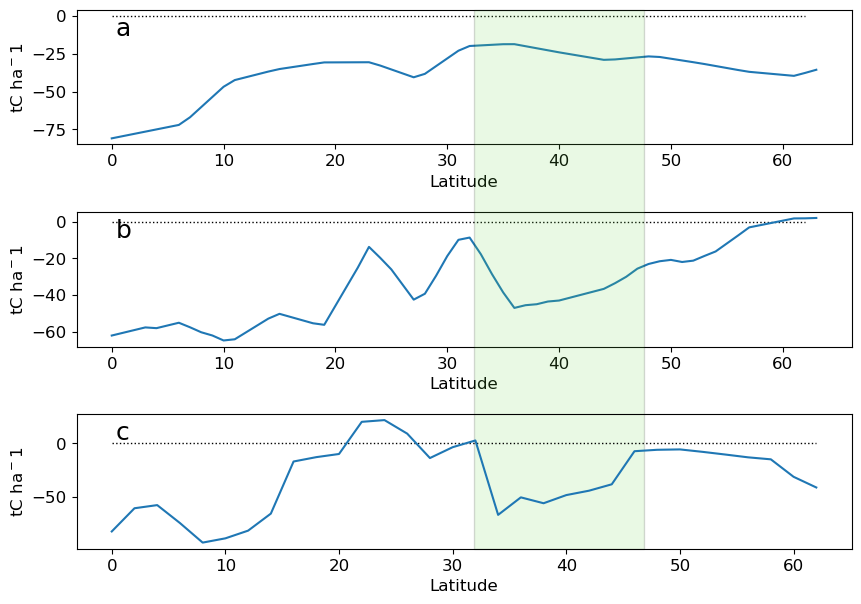

In [58]:
# Plot panel in carbon equivalent.
fig, axs = plt.subplots(3, figsize = (10, 7))
fig.subplots_adjust(wspace = 0.1, hspace = 0.5)

# Figure 1.
dc = -DeltaC  
axs[0].plot(dc[:64])
axs[0].set_ylabel("tC ha$^-1$")
axs[0].text(0.05, 0.95, 'a', transform = axs[0].transAxes, fontsize = 18, va = 'top')
axs[0].set_ylabel("tC ha$^-1$")
axs[0].hlines(0.0, 0, latitudes[-4], linestyle = ":", linewidth = 1, label = '')
axs[0].set_xlabel("Latitude")
# Figure 2.
dc0 = dc[:64] + RF_to_Ceq(annual_radiation_data_no_winter["SW"][:64].values)*10000    
axs[1].plot(dc0)
axs[1].set_ylabel("tC ha$^-1$")
axs[1].text(0.05, 0.95, 'b', transform = axs[1].transAxes, fontsize = 18, va = 'top')
axs[1].hlines(0.0, 0, latitudes[-4], linestyle = ":", linewidth = 1, label = '')
axs[1].set_xlabel("Latitude")
# Figure 3.
dc1 = dc[:63:2] + RF_to_Ceq(annual_radiation_data_no_winter["Model"][:63:2].values)*10000 
axs[2].plot(latitudes[:63:2], dc1)
axs[2].set_ylabel("tC ha$^-1$")
axs[2].set_xlabel("Latitude")
axs[2].hlines(0.0, 0, latitudes[-4], linestyle = ":", linewidth = 1, label = '')
axs[2].text(0.05, 0.95, 'c', transform = axs[2].transAxes, fontsize = 18, va = 'top')

rect = mpatches.Rectangle([0.522, 0.110], 0.17, 0.770, ec = 'k', fc = '#6ddb4b', alpha = 0.15, 
                          clip_on = False, transform = fig.transFigure)
axs[2].add_patch(rect)

# Save figure.
fig.savefig("./Figures/4. Plot/panel2.png", dpi = 1200)